In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

## Lecture du csv

In [3]:
df = pd.read_csv("Train.csv")

## Affichage d'un échantillon de la dataset

In [5]:
df.sample(5)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
7458,Order_No_24969,User_Id_3647,Bike,3,Business,1,5,4:01:54 PM,1,5,...,5:04:02 PM,20,28.4,NaN,-1.272639,36.794723,-1.377086,36.754606,Rider_Id_31,2775
5722,Order_No_25500,User_Id_265,Bike,3,Business,22,5,10:30:47 AM,22,5,...,11:30:42 AM,11,NaN,NaN,-1.300921,36.828195,-1.345962,36.907393,Rider_Id_127,2972
13422,Order_No_10586,User_Id_1594,Bike,3,Business,16,2,3:11:54 PM,16,2,...,4:07:34 PM,12,NaN,NaN,-1.288780,36.816831,-1.215601,36.891686,Rider_Id_709,1731
5092,Order_No_17805,User_Id_439,Bike,3,Business,15,4,10:00:06 AM,15,4,...,11:05:44 AM,15,19.6,NaN,-1.332311,36.869262,-1.296808,36.787098,Rider_Id_387,2800
4074,Order_No_26951,User_Id_2412,Bike,3,Business,24,5,2:12:35 PM,24,5,...,3:01:39 PM,15,22.8,NaN,-1.228340,36.882276,-1.255189,36.782203,Rider_Id_788,1572


## Affichage des catégories de la colomne Vehicle Type

<AxesSubplot:xlabel='Vehicle Type'>

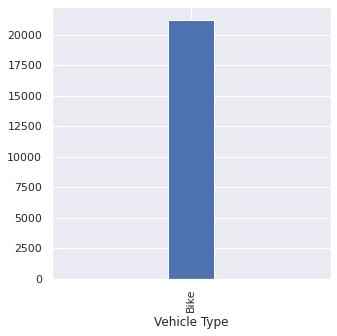

In [6]:
df.groupby("Vehicle Type").size().plot(kind="bar", figsize=(5, 5), width=0.1)

## Affichage des catégories de la colomne Personal or Business

<AxesSubplot:xlabel='Personal or Business'>

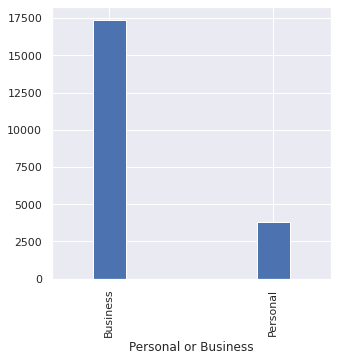

In [7]:
df.groupby("Personal or Business").size().plot(kind='bar', figsize=(5, 5), width=0.2)

## Affichage du nombre de jours présents dans la base de donnée

### Methode 1: pandas

In [8]:
days = ["Monday", "Tuesday", "Wesdnesday", "Thursday", "Friday", "Saturday", "Sunday"]

In [9]:
idx2days = { idx+1:days[idx] for idx in range(7) }
idx2days

{1: 'Monday',
 2: 'Tuesday',
 3: 'Wesdnesday',
 4: 'Thursday',
 5: 'Friday',
 6: 'Saturday',
 7: 'Sunday'}

In [10]:
df["Arrival at Destination - WeekDays"] = df[["Arrival at Destination - Weekday (Mo = 1)"]].replace(idx2days)

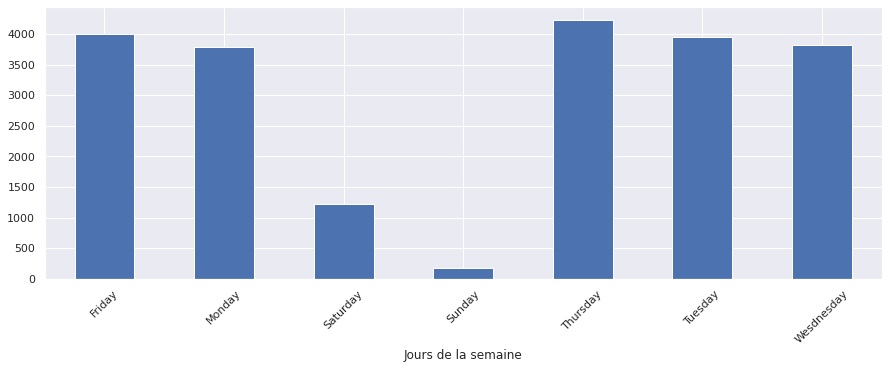

In [11]:
_ = df.groupby("Arrival at Destination - WeekDays").size().plot(kind="bar", figsize=(15, 5), xlabel="Jours de la semaine", rot=45)

### Methode 2: matplotlib

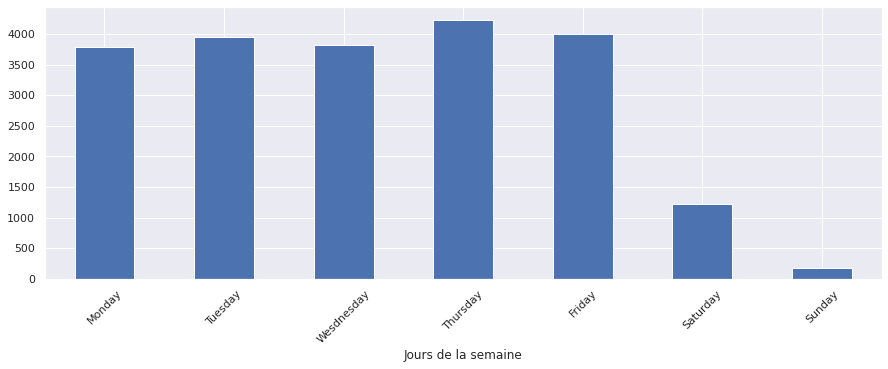

In [12]:
_ = df.groupby("Arrival at Destination - Weekday (Mo = 1)").size().plot(kind="bar", figsize=(15, 5), xlabel="Jours de la semaine", rot=45).set_xticklabels(days)

## Delai d'acceptation

<AxesSubplot:ylabel='Frequency'>

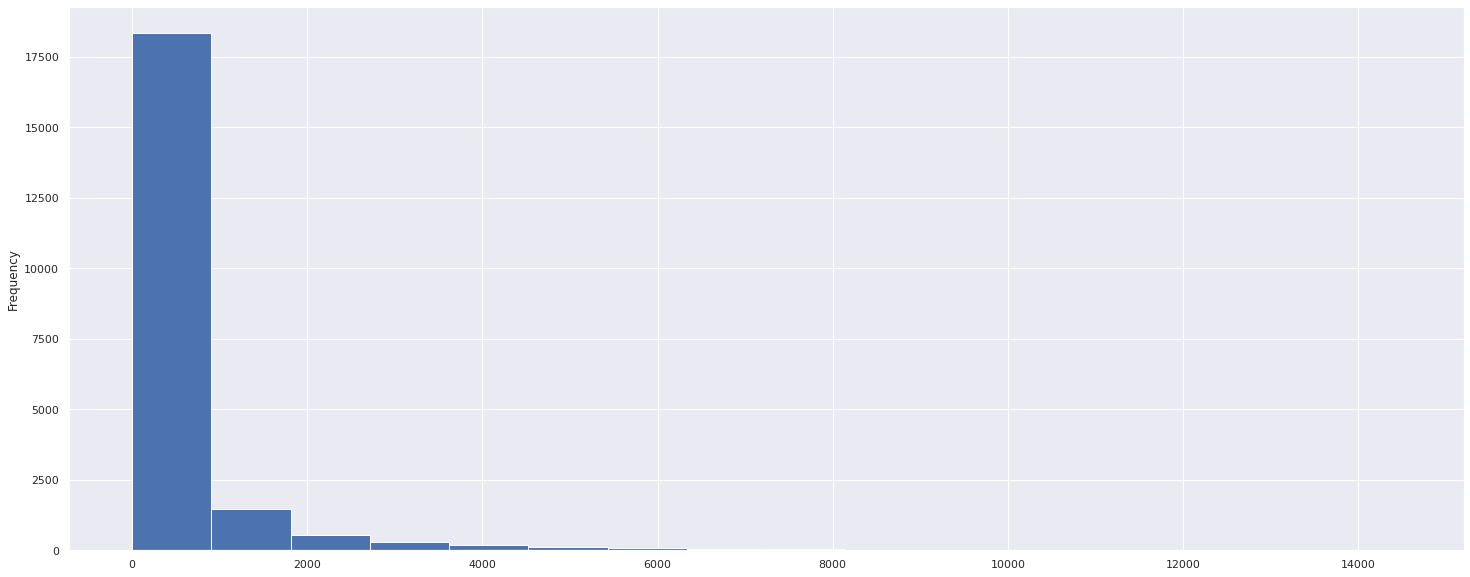

In [13]:
# On cacule la difference de temps entre le placement de la commande et sa confirmation
df['acceptation_time_delta'] = pd.to_datetime(df['Confirmation - Time']) - pd.to_datetime(df['Placement - Time'])

# On convertit le temps en float, pour pouvoir l'afficher correctement avec plot
df['acceptation_time_delta'] = df['acceptation_time_delta'].dt.total_seconds()

# On affiche l'histogramme du delta, en ignorant les donnees aberrantes (temps negatifs ici)
df['acceptation_time_delta'].loc[df['acceptation_time_delta'] > 0].plot(kind='hist', figsize=(25, 10), bins=16)

## Calcul de la vitesse moyenne

### Verifications prealable

In [14]:
# On verifie au prealable qu'il n'y a pas de temps nuls
df['Time from Pickup to Arrival'].describe()

count    21201.000000
mean      1556.920947
std        987.270788
min          1.000000
25%        882.000000
50%       1369.000000
75%       2040.000000
max       7883.000000
Name: Time from Pickup to Arrival, dtype: float64

Le temps minimal est d'une seconde, ce qui apparait comme une donnee aberrante, mais ne nous empeche pas d'effectuer notre division. 

### Calcul et affichage

On a ignoré 4.30% des données.


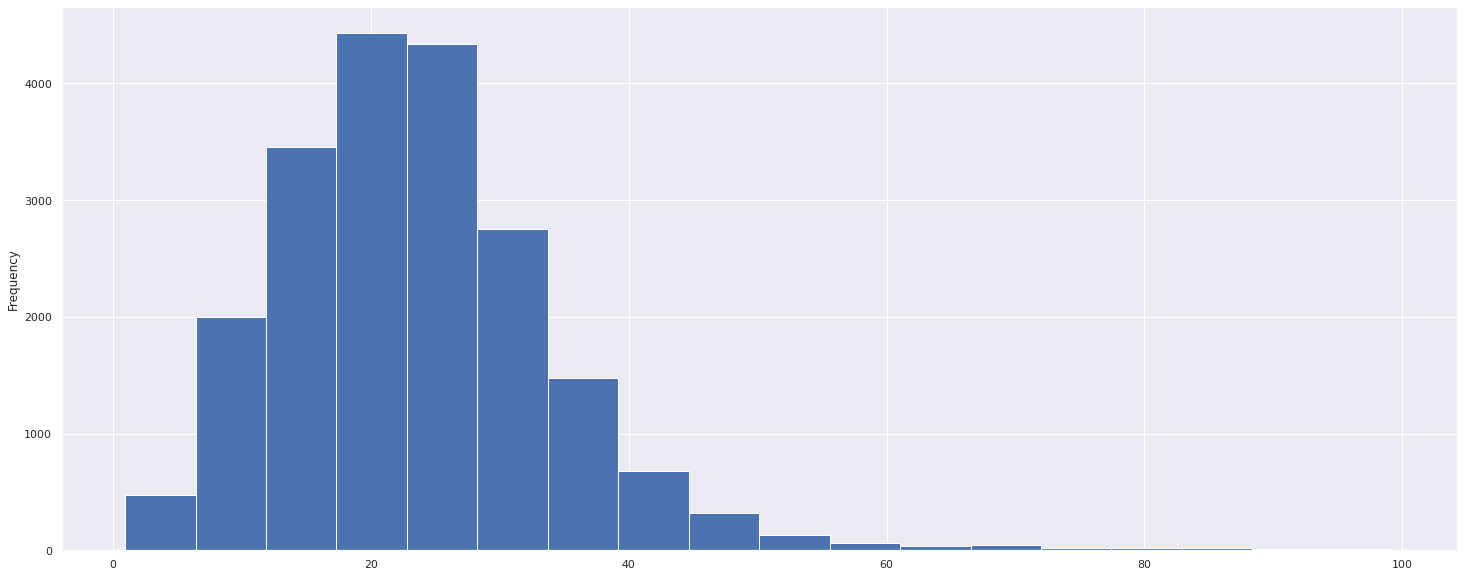

In [15]:
# On calcule la vitesse avec la formule v = d / t
df['speed_km/h'] = df['Distance (KM)'] / df['Time from Pickup to Arrival']

# On convertit en km/h
df['speed_km/h'] *= 3600

# On affiche l'histogramme de la vitesse, en ignorant les donnes aberrantes (ici une vitesse supperieure a 100 km/h)
# On affiche le nombre de lignes ainsi ignorees
df['speed_km/h'].loc[df['speed_km/h'] < 100].plot(kind='hist', bins=18, figsize=(25, 10))
print(f"On a ignoré {sum(df['speed_km/h'] > 100) / 21201 * 100:.2f}% des données.")

### Data engineering

Lorsqu'on analyse les temps de livraison, on se rend compte que certaines valeurs sont absurdes. Cependant, il est difficile de determiner efficacement les donnes aberrantes en utilisant uniquement cette duree, car il pourrait s'agir de courses tres courtes.

On decide de s'appuyer sur la distance en km, qui est probablement moins sujet a des erreurs, et peut etre verifiee a l'aide des donnes geographiques. On a calcule a l'etape precedente la vitesse moyenne de chaque course, ce qui nous permet d'ecarter 911 echantillons ayant un temps de livraison trop court, car ils resulteraient en une vitesse moyenne de plus de 100 km/h. Pour un velo, c'est beaucoup trop rapide !

Comment replacer ces durees dans le dataframe ? On se propose de leur substituer une duree calculee a partir de la distance de chaque echantillon et de la vitesse moyenne des courses.

<AxesSubplot:ylabel='Frequency'>

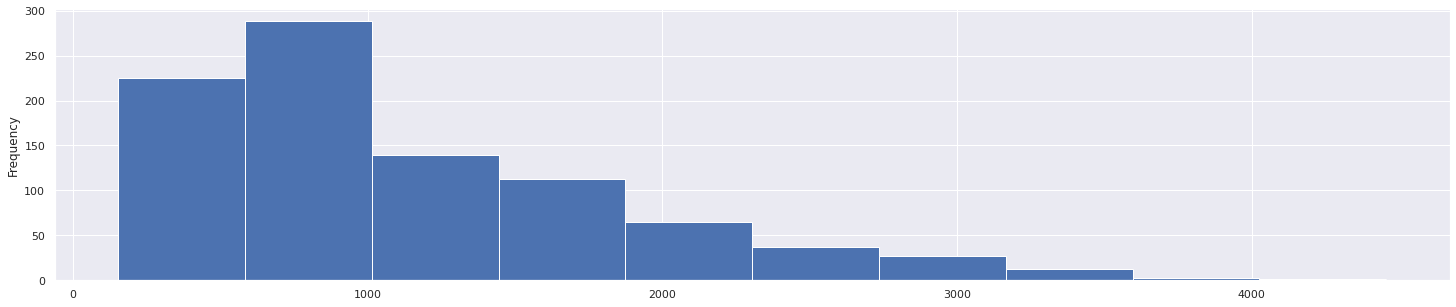

In [16]:
# On se fixe une vitesse au dessus de laquelle les courses sont considerees fausses
speed_threshold = 100

# On selectionne les colomnes qui correspondent a des durees de courses trop courtes
# On copie le dataframe pour etre sur de ne pas modifier l'original
df_time2fix = pd.DataFrame(df[df['speed_km/h'] > speed_threshold])

# On calcule la vitesse moyenne pour les courses validees
mean_speed = df['speed_km/h'].loc[df['speed_km/h'] < speed_threshold].mean()

# On calcule la duree corrigee en appliquant la formule v = d / t
# On la converti en secondes
df_time2fix['Time from Pickup to Arrival'] = df_time2fix['Distance (KM)'] / mean_speed * 3600

# On visualise les temps produits
df_time2fix['Time from Pickup to Arrival'].plot(kind='hist', figsize=(25, 5))

## Mise en relation avec les livreurs (Riders.csv)

### Jointure avec la base Train.csv

In [17]:
df_riders = pd.read_csv("Riders.csv")

On verifie que les identifiants des riders du dataframe principal sont presents dans la liste des riders

In [18]:
df['Rider Id'].isin(df_riders['Rider Id']).all()

True

On peut donc merger les deux dataframes

In [19]:
df_merged = pd.merge(df, df_riders, how='inner', on='Rider Id', validate='m:1')
df_merged.shape

(21201, 36)

### Visualisation des notes des livreurs

On a ignoré 3.33% des données (nombre de notations <= 1).


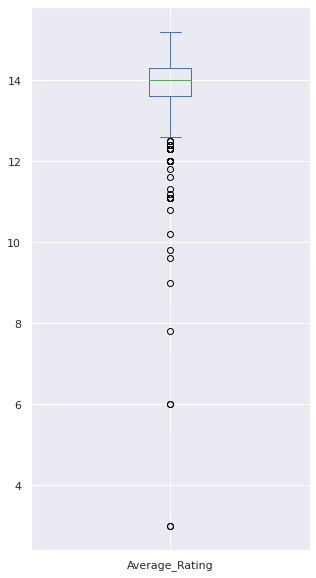

In [20]:
df_riders['Average_Rating'].loc[df_riders['No_of_Ratings'] > 1].plot(kind='box', figsize=(5, 10))
print(f"On a ignoré {sum(df_riders['No_of_Ratings'] <= 1) / 960 * 100:.2f}% des données (nombre de notations <= 1).")

### Relations entre la note des livreurs et la duree de la livraison

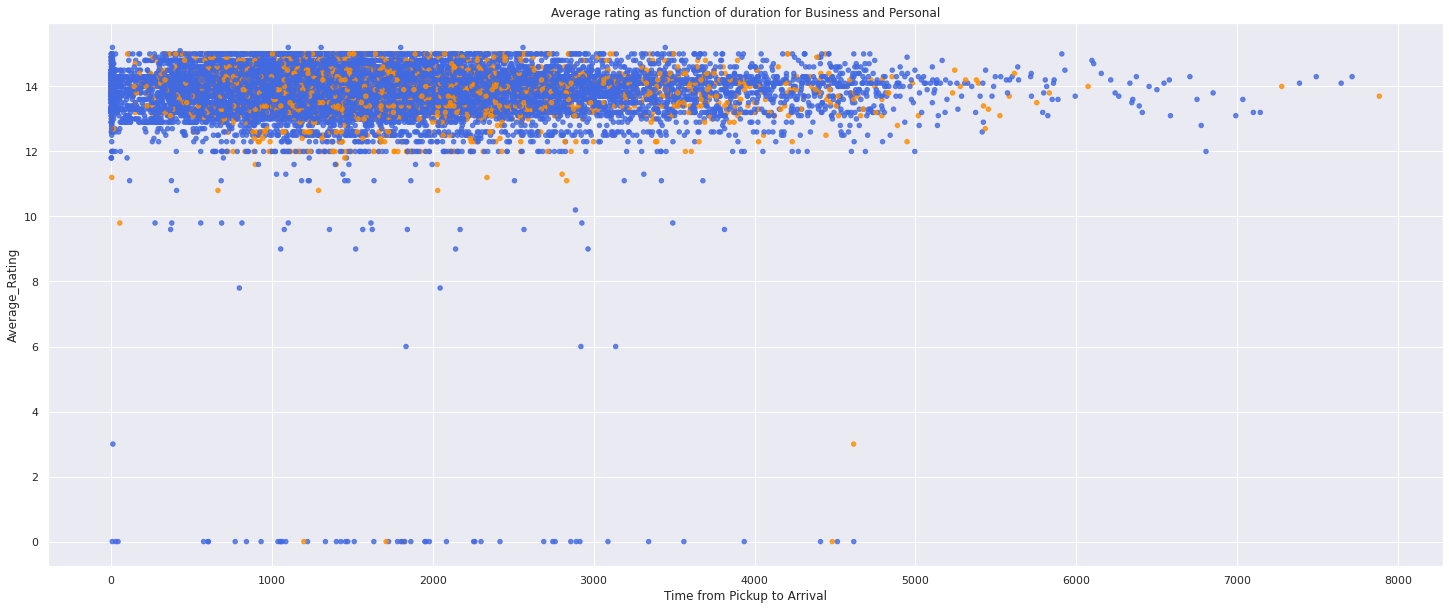

In [21]:
colors = {
    'Business': 'royalblue',
    'Personal': 'darkorange'
}

ax = df_merged.plot.scatter(x='Time from Pickup to Arrival',
                            y='Average_Rating',
                            c=df_merged['Personal or Business'].map(colors),
                            alpha=0.8,
                            title='Average rating as function of duration for Business and Personal',
                            figsize=(25, 10))

On remarque que la note semble etre independante de la duree de livraison. Il en va de meme pour la vitesse moyenne de la livraison :

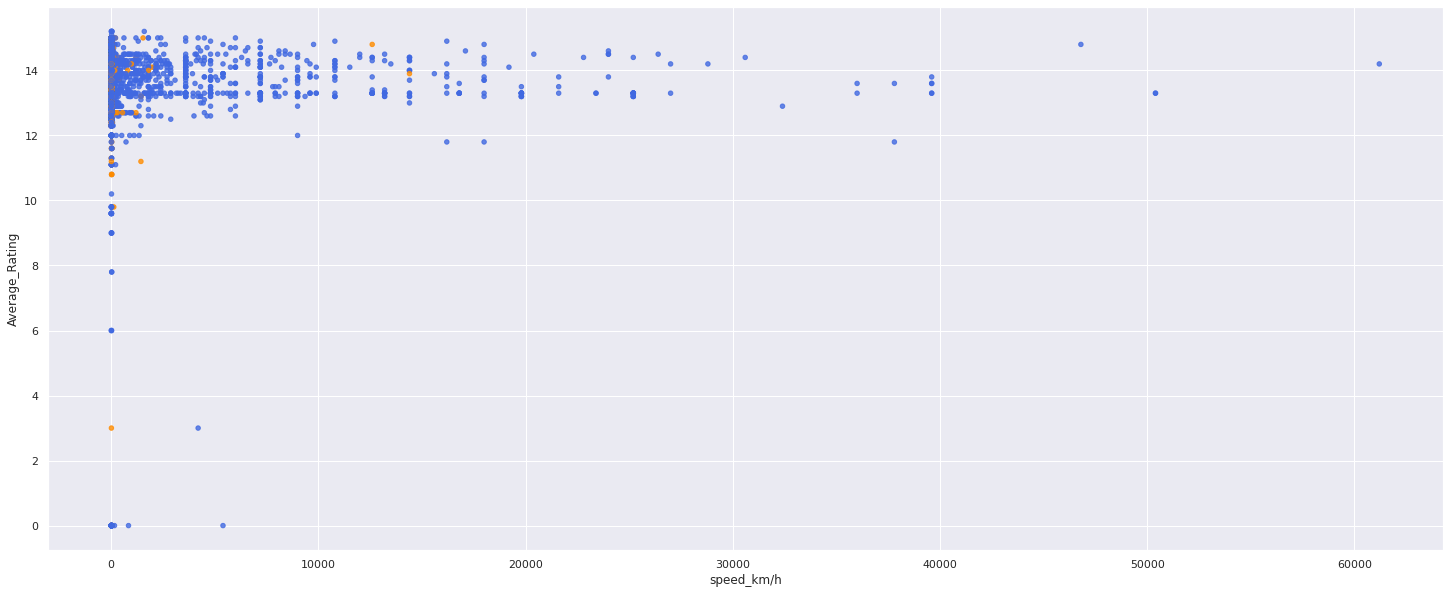

In [22]:
ax = df_merged.plot.scatter(x='speed_km/h',
                            y='Average_Rating',
                            c=df_merged['Personal or Business'].map(colors),
                            alpha=0.8,
                            figsize=(25, 10))

### Analyse du rating rate

Le rating rate est la frequence moyenne a laquelle les courses sont notees par les utilisateurs.

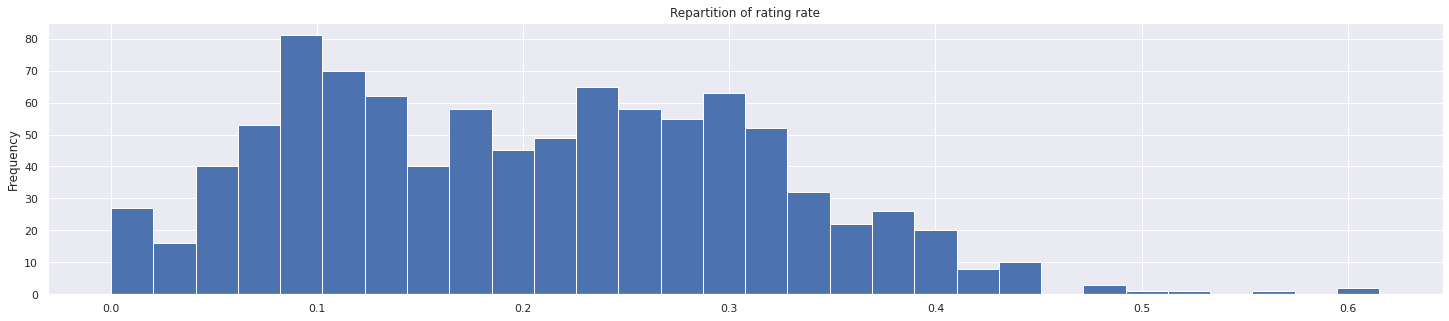

In [23]:
df_riders['rating_rate'] = df_riders['No_of_Ratings'] / df_riders['No_Of_Orders']

ax = df_riders['rating_rate'].plot(kind='hist', figsize=(25, 5), bins=30, title='Repartition of rating rate')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 32 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

## Bonus

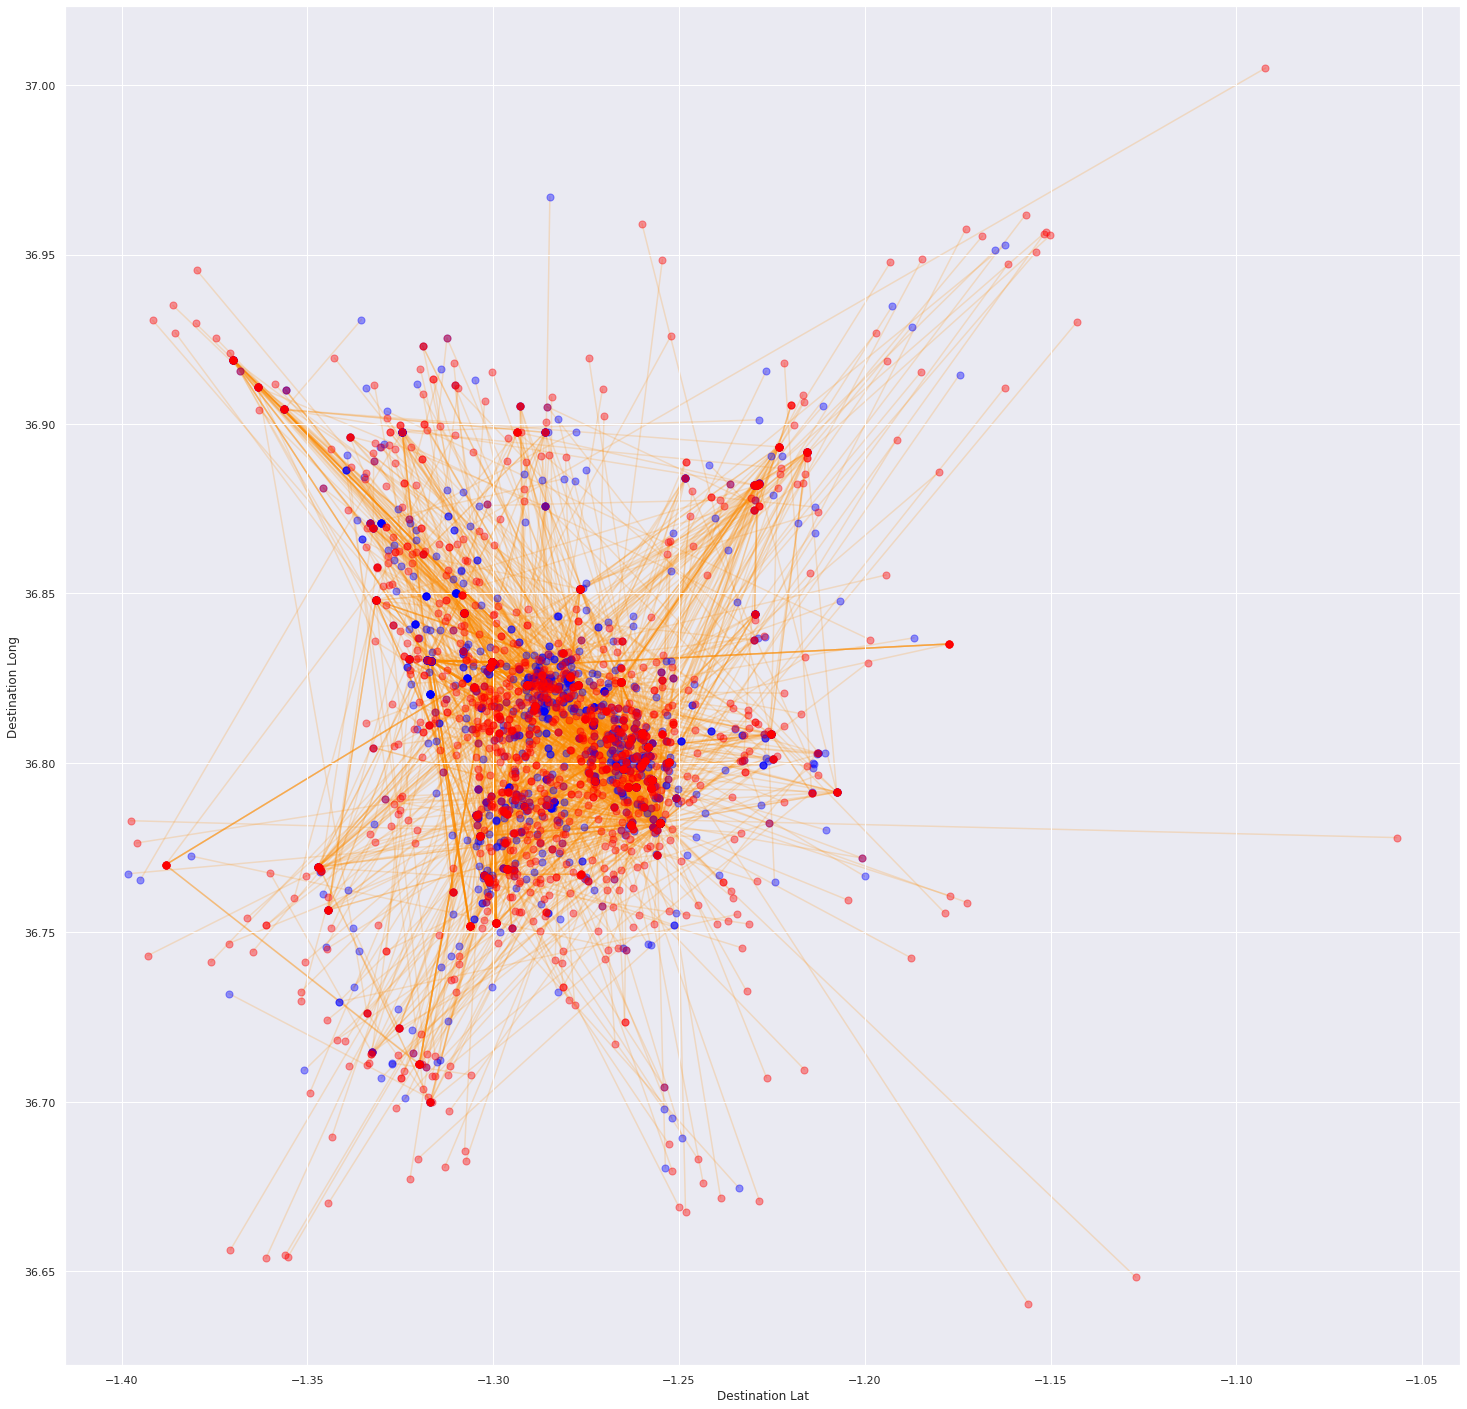

In [25]:
def plot_geodata(df, figsize=10, pointsize=50):
    # Plot pickup spot
    ax = df.plot(kind='scatter', x='Pickup Lat', y='Pickup Long', c='blue', alpha=0.4, s=pointsize, figsize=(figsize, figsize))
    
    # Plot destination spot
    ax = df.plot(kind='scatter', x='Destination Lat', y='Destination Long', c='red', alpha=0.4, s=pointsize, ax=ax)
    
    # Plot lines between pickup and destination
    x_values = df[['Pickup Lat', 'Destination Lat']].values
    y_values = df[['Pickup Long', 'Destination Long']].values
    for x, y in zip(x_values, y_values):
        ax.plot(x, y, alpha=0.2, color='darkorange', zorder=-1)
        
plot_geodata(df.sample(2000), figsize=25)